## Neural network classification with PyTorch

## 1. Make classsification data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

In [ ]:
## Make 1000 samples
n_samples=1000
x,y= make_circles(n_samples,noise=0.03,random_state=42)

In [ ]:
len(x),len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X: {x[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [ ]:
## Make Dataframe of circle data
import pandas as pd
circles= pd.DataFrame({"x1":x[:,0],"x2": x[:,1],"y":y})

In [ ]:
circles.head()

,x1,x2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


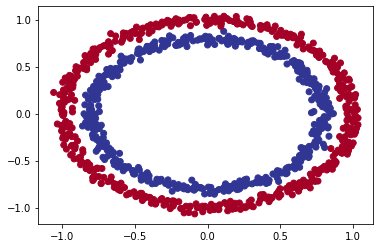

In [ ]:
## visualize
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

## 1.1 Check input and output shapes

In [ ]:
x.shape,y.shape

((1000, 2), (1000,))

In [ ]:
## view the first example of features and lables

x_sample= x[0]
y_sample= y[0]

print(f"values for one sample of x:{x_sample} and the sample for y : {y_sample}")
print(f"values for one sample of x:{x_sample.shape} and the sample for y : {y_sample.shape}")

values for one sample of x:[0.75424625 0.23148074] and the sample for y : 1
values for one sample of x:(2,) and the sample for y : ()


## Turn data into tensors

In [ ]:
import torch
torch.__version__

'1.12.1+cu113'

In [ ]:
type(x)

numpy.ndarray

In [ ]:
x=torch.from_numpy(x).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)

x[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [ ]:
## split data into training and test sets

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,
                                               random_state=42,shuffle=True)

In [ ]:
len(x_train),len(x_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [ ]:
import torch 
from torch import nn

## make device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
## 1. construct a model that subclasses nn.Module
class classificationmodel(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
    # define forward() method that outlines the forward pass

    def forward(self,x:torch.Tensor) -> torch.Tensor:
          return self.layer_2(self.layer_1(x)) # x->layer_1 -> layer_2 -> output
  
## Instantitate an instance of our model clas and send it to the target device

model_0= classificationmodel().to(device)
model_0

classificationmodel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

In [ ]:
next(model_0.parameters()).to(device)

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], requires_grad=True)

In [ ]:
## Let's replicate thr model above using nn.sequentila()

model_0 =nn.Sequential(nn.Linear(in_features=2,out_features=5),
                       nn.Linear(in_features=5,out_features=1)).to(device)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [ ]:
with torch.inference_mode():
    pred=model_0(x_train.to(device))           ## not good prediction
pred[ :5],y_train[:5],len(pred),pred.shape

(tensor([[ 0.2826],
         [ 0.3236],
         [ 0.0202],
         [ 0.0421],
         [-0.0271]]), tensor([1., 0., 0., 0., 1.]), 800, torch.Size([800, 1]))

## setup loss function and optimizer


In [ ]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right? 
def accuracy_fn(y_true,y_pred):
  correct= torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred)) *100
  return acc

**3. Train model**

To train our model, we're going to need to build a training loop with the following steps:

1.Forward pass

2.Calculate the loss

3.Optimizer zero grad

4.Loss backward (backpropagation)

5.Optimizer step (gradient descent)

**3.1 Going from raw logits -> prediction probabilities -> prediction labels
Our model outputs are going to be raw logits.**

We can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax().

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits= torch.round(torch.sigmoid(model_0(x_test.to(device))[:5]))
y_logits.squeeze()

tensor([0., 0., 1., 0., 1.])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42) 
epoch=100
x_train=x_train.to(device)
x_test=x_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)
for epoch in range(epoch):
  ##Training
  model_0.train()
  y_logits=model_0(x_train).squeeze()
  y_pred= torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc= accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## Testing
  model_0.eval()
  with torch.inference_mode():
    test_logit= model_0(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logit))
    test_loss=loss_fn(test_logit,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
  if epoch %10==0:
   print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")






Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test loss: 0.69460, Test acc: 57.50%
Epoch: 10 | Loss: 0.69768, Acc: 52.00% | Test loss: 0.69438, Test acc: 58.00%
Epoch: 20 | Loss: 0.69742, Acc: 52.00% | Test loss: 0.69418, Test acc: 57.50%
Epoch: 30 | Loss: 0.69717, Acc: 52.00% | Test loss: 0.69401, Test acc: 56.50%
Epoch: 40 | Loss: 0.69695, Acc: 51.62% | Test loss: 0.69385, Test acc: 56.50%
Epoch: 50 | Loss: 0.69675, Acc: 51.38% | Test loss: 0.69370, Test acc: 56.00%
Epoch: 60 | Loss: 0.69656, Acc: 51.38% | Test loss: 0.69357, Test acc: 56.00%
Epoch: 70 | Loss: 0.69638, Acc: 51.38% | Test loss: 0.69345, Test acc: 56.50%
Epoch: 80 | Loss: 0.69621, Acc: 51.25% | Test loss: 0.69334, Test acc: 56.50%
Epoch: 90 | Loss: 0.69606, Acc: 51.38% | Test loss: 0.69324, Test acc: 55.00%


## **4. Make predictions and evaluate the model **
From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called plot_decision_boundary() - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

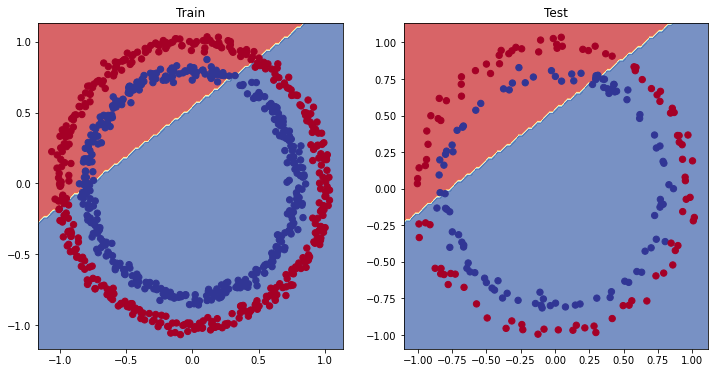

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

##5. Improving a model (from a model perspective)

Add more layers - give the model more chances to learn about patterns in the data.

1.Add more hidden units - go from 5 hidden units to 10 hidden units
Fit for longer

2.Changing the activation functions.

3.Change the learning rate

4.Change the loss function.

These options are all from a model's perspective because they deal directly with the model, rather than the data.


In [ ]:
class circlemodelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=20)
    self.layer_3=nn.Linear(in_features=20,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x:torch.Tensor)->torch.Tensor:
    #z=self.layer_1(x)
    #z=self.layer_2(z)
    #z=self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed

model_1 = circlemodelv1().to(device)
model_1


circlemodelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
next(model_1.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802]], requires_grad=True)

In [ ]:
## creating loss function

loss_fn = nn.BCEWithLogitsLoss() 

## creating optimizer

optimizer= torch.optim.Adam(params=model_1.parameters(),lr=0.0001)

In [ ]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'params': [0, 1, 2, 3, 4, 5]}]}

In [ ]:
## training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000
x_train=x_train.to(device)
x_test=x_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)
for epoch in range(epochs):
  model_1.train()
  y_logits=model_1(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  ##evaluation
  model_1.eval()
  with torch.inference_mode():
    y_test_logits=model_1(x_test).squeeze()
    y_test_pred=torch.round(torch.sigmoid(y_test_logits))
    test_loss=loss_fn(y_test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=y_test_pred)
  if epoch %100 == 0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69460, Acc: 51.62% | Test loss: 0.69733, Test acc: 50.00%
Epoch: 100 | Loss: 0.69313, Acc: 51.00% | Test loss: 0.69581, Test acc: 46.50%
Epoch: 200 | Loss: 0.69299, Acc: 50.88% | Test loss: 0.69501, Test acc: 47.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.38% | Test loss: 0.69473, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


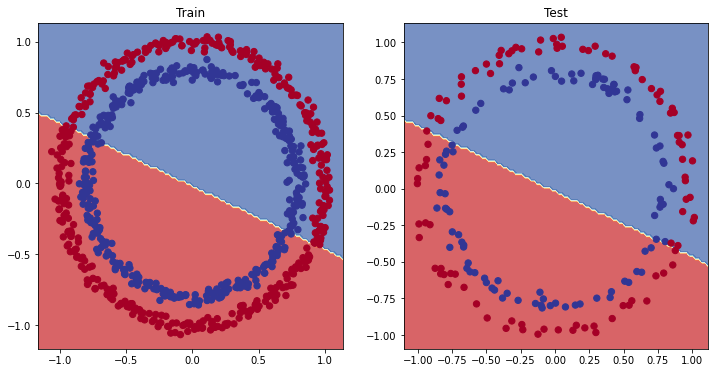

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, x_test, y_test)

##Building a model with non-linearity

1.Linear = straight lines

2.Non-linear = non-straight lines


Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

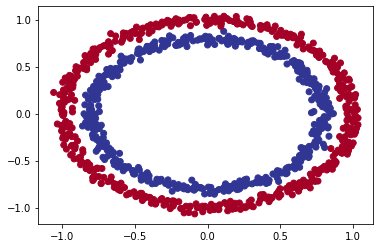

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples=1000
x,y=make_circles(n_samples,noise=0.03,random_state=42)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
from sklearn.model_selection import train_test_split
import torch

x=torch.from_numpy(x).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [ ]:
from torch import nn
class circlemodelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=20)
    self.layer_2 = nn.Linear(in_features=20, out_features=30)
    self.layer_3 = nn.Linear(in_features=30, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function
    
  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = circlemodelv2().to(device)
model_2

circlemodelv2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
list(model_2.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802],
         [-0.3258, -0.0829],
         [-0.2872,  0.4691],
         [-0.5582, -0.3260],
         [-0.1997, -0.4252],
         [ 0.0667, -0.6984],
         [ 0.6386, -0.6007],
         [ 0.5459,  0.1177],
         [-0.2296,  0.4370],
         [ 0.1102,  0.5713],
         [ 0.0773, -0.2230]], requires_grad=True), Parameter containing:
 tensor([ 0.1900, -0.1918,  0.2976,  0.6313,  0.4087, -0.3091,  0.4082,  0.1265,
          0.3591, -0.4310, -0.7000, -0.2732, -0.5424,  0.5802,  0.2037,  0.2929,
          0.2236, -0.0123,  0.5534, -0.5024], requires_grad=True), Parameter containing:
 tensor([[ 0.0141, -0.1526,  0.0689, -0.0770,  0.0685, -0.0466,  0.1855, -0.1325,
          -0.1334, -

In [ ]:
## setup loss and optimizer
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(model_2.parameters(),lr=0.001)


In [ ]:
#Training a model with non-linearity
epochs=1000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()
  y_logits=model_2(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  loss= loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  ## evaluation
  model_2.eval()
  with torch.inference_mode():
    y_test_logits=model_2(x_test).squeeze()
    y_pred_test=torch.round(torch.sigmoid(y_test_logits))
    test_loss=loss_fn(y_test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=y_pred_test)
  if epoch %100 == 0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69427, Acc: 50.88% | Test loss: 0.69531, Test acc: 49.00%
Epoch: 100 | Loss: 0.64377, Acc: 74.75% | Test loss: 0.64540, Test acc: 75.50%
Epoch: 200 | Loss: 0.43683, Acc: 98.75% | Test loss: 0.46780, Test acc: 96.50%
Epoch: 300 | Loss: 0.20783, Acc: 99.88% | Test loss: 0.25184, Test acc: 99.00%
Epoch: 400 | Loss: 0.09896, Acc: 100.00% | Test loss: 0.13699, Test acc: 100.00%
Epoch: 500 | Loss: 0.05445, Acc: 100.00% | Test loss: 0.08248, Test acc: 100.00%
Epoch: 600 | Loss: 0.03334, Acc: 100.00% | Test loss: 0.05463, Test acc: 100.00%
Epoch: 700 | Loss: 0.02282, Acc: 100.00% | Test loss: 0.04067, Test acc: 100.00%
Epoch: 800 | Loss: 0.01672, Acc: 100.00% | Test loss: 0.03232, Test acc: 100.00%
Epoch: 900 | Loss: 0.01284, Acc: 100.00% | Test loss: 0.02665, Test acc: 100.00%


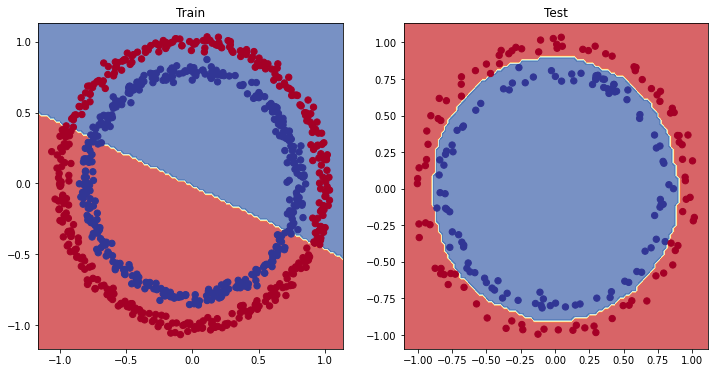

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, x_test, y_test)

##Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [ ]:
## create a tensor
a=torch.arange(-10,10,1,dtype=torch.float32)
a.dtype

torch.float32

In [ ]:
a

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

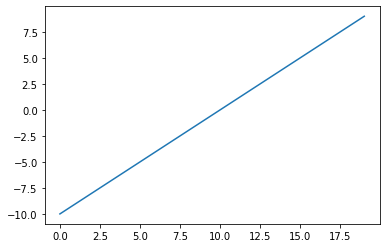

In [ ]:
plt.plot(a)

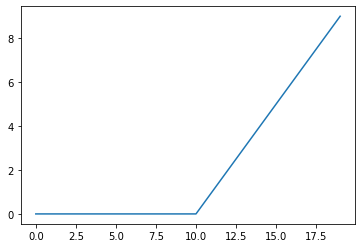

In [ ]:
plt.plot(torch.relu(a))

In [ ]:
def relu(x:torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)
relu(a)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

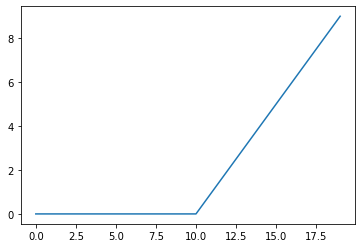

In [ ]:
# Plot ReLU activation function
plt.plot(relu(a));

## putting all together with a multi-class classification

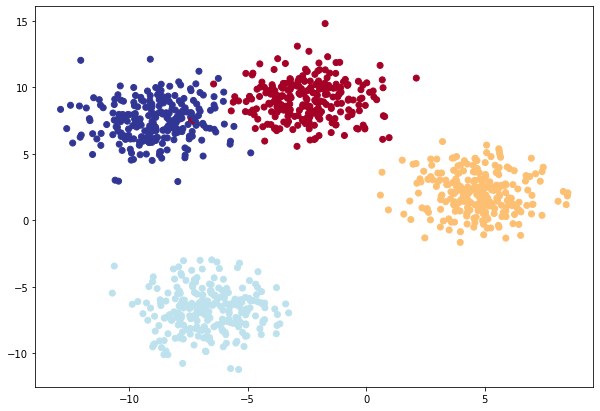

In [ ]:
## creating a toy mulyi-class dataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## set the hyperparameters for data creation

NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED= 42

# 1. CREATE MULTI-CLASS DATA

x_blob,y_blob= make_blobs(n_samples=1000,
                          n_features=NUM_FEATURES,
                          centers=NUM_CLASSES,
                          cluster_std=1.5,  #give the clusters a little shake up
                          random_state=RANDOM_SEED)

## 2. turn data into tensors
x_blob=torch.from_numpy(x_blob).type(torch.float32)
y_blob= torch.from_numpy(y_blob).type(torch.LongTensor)

## train test split

x_train,x_test,y_train,y_test=train_test_split(x_blob,y_blob,test_size=0.2,random_state=41)

plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)


## Building a multi-class classification model in PyTorch

---
1.with non-linearity

2.without non-linearity


In [ ]:
# device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class blobmodel(nn.Module):  #### without non-linearity
  def __init__(self,**kwargs):
    """Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8 """
    super().__init__()
    self.input_features=kwargs["input_features"]
    self.output_features=kwargs["output_features"]
    self.hidden_units=kwargs["hidden_unit"]
    # layer init
    self.linear_layer_sequential=nn.Sequential(
        nn.Linear(in_features=self.input_features,out_features=self.hidden_units),
        nn.Linear(in_features=self.hidden_units,out_features=self.hidden_units),
        nn.Linear(in_features=self.hidden_units,out_features=self.output_features))
  def forward(self,x:torch.Tensor)->torch.Tensor :
    return self.linear_layer_sequential(x)

model_3=blobmodel(input_features=2,
                  output_features=4,
                  hidden_unit=8).to(device)
model_3





blobmodel(
  (linear_layer_sequential): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
print(next(model_3.parameters()))

Parameter containing:
tensor([[ 0.3988,  0.2571],
        [ 0.5602, -0.2648],
        [ 0.2380,  0.2516],
        [-0.5887, -0.6859],
        [-0.3669,  0.4840],
        [-0.6657, -0.6155],
        [ 0.3961,  0.3815],
        [ 0.5815, -0.5338]], requires_grad=True)


In [ ]:
print(model_3.state_dict())

OrderedDict([('linear_layer_sequential.0.weight', tensor([[ 0.3988,  0.2571],
        [ 0.5602, -0.2648],
        [ 0.2380,  0.2516],
        [-0.5887, -0.6859],
        [-0.3669,  0.4840],
        [-0.6657, -0.6155],
        [ 0.3961,  0.3815],
        [ 0.5815, -0.5338]])), ('linear_layer_sequential.0.bias', tensor([-0.5175,  0.3627,  0.6149,  0.4231,  0.1108,  0.2330,  0.6711, -0.4562])), ('linear_layer_sequential.1.weight', tensor([[-0.1605,  0.2473, -0.2419, -0.1950,  0.2581,  0.1116,  0.1142, -0.1499],
        [-0.0049,  0.3236, -0.2122,  0.0028,  0.1681, -0.2441,  0.3434, -0.1766],
        [-0.0849, -0.0957, -0.2304, -0.3469,  0.1994,  0.0939, -0.3311, -0.2276],
        [ 0.3494,  0.1351,  0.1419, -0.2115, -0.1550, -0.0534, -0.0647, -0.2423],
        [ 0.0291,  0.0351, -0.0448,  0.0490, -0.1401,  0.0920,  0.1333, -0.1862],
        [-0.3506,  0.1851,  0.0843, -0.1798,  0.3407, -0.1599,  0.2389,  0.1794],
        [-0.2964,  0.2280, -0.3251, -0.1959, -0.0589, -0.2383,  0.3454, -0.0

In [ ]:
## Create a loss function and an optimizer for a multi-class classification model

loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params=model_3.parameters(),lr=0.1)

In [ ]:
# Let's get some raw outputs of our model (logits)
model_3.eval()
with torch.inference_mode():
  y_logits=model_3(x_train)
print(y_logits[:10])

tensor([[ 2.0311, -1.5814,  2.1543,  0.1982],
        [ 2.5916, -0.2322,  0.6078, -2.4974],
        [ 1.1656,  0.7727, -0.7071, -2.2137],
        [ 1.0937,  1.1663, -1.1791, -2.7075],
        [ 1.1854,  1.6460, -1.7384, -3.5321],
        [ 2.5374, -0.0162,  0.3475, -2.7501],
        [ 2.8618, -0.1161,  0.4944, -3.0053],
        [ 2.5527, -0.2462,  0.6209, -2.4284],
        [ 0.9200,  1.5355, -1.6312, -3.0386],
        [ 2.6987, -0.1628,  0.5353, -2.7333]])


In [ ]:
y_pred=torch.softmax(y_logits,dim=1)
print(y_pred[:5])
print(y_pred.argmax(dim=1)[:5])

tensor([[0.4314, 0.0116, 0.4880, 0.0690],
        [0.8312, 0.0494, 0.1143, 0.0051],
        [0.5368, 0.3624, 0.0825, 0.0183],
        [0.4544, 0.4886, 0.0468, 0.0102],
        [0.3777, 0.5986, 0.0203, 0.0034]])
tensor([2, 0, 0, 1, 1])


In [ ]:
def accuracy_fn(y_true,y_pred):
  acc=(y_true==y_pred).sum().item()/len(y_true)
  return acc

In [ ]:
#Creating a training loop and testing loop for a multi-class PyTorch model

torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=100

x_train,y_train,x_test,y_test=x_train.to(device),y_train.to(device),x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_3.train()
  y_logits=model_3(x_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## testing
  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(x_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.8685, Acc: 0.58% | Test loss: 0.8383, Test acc: 0.74%
Epoch: 10 | Loss: 0.1426, Acc: 0.99% | Test loss: 0.1298, Test acc: 0.99%
Epoch: 20 | Loss: 0.0748, Acc: 0.99% | Test loss: 0.0739, Test acc: 0.99%
Epoch: 30 | Loss: 0.0540, Acc: 0.99% | Test loss: 0.0570, Test acc: 0.99%
Epoch: 40 | Loss: 0.0440, Acc: 0.99% | Test loss: 0.0492, Test acc: 0.99%
Epoch: 50 | Loss: 0.0382, Acc: 0.99% | Test loss: 0.0450, Test acc: 0.99%
Epoch: 60 | Loss: 0.0344, Acc: 0.99% | Test loss: 0.0425, Test acc: 0.99%
Epoch: 70 | Loss: 0.0317, Acc: 0.99% | Test loss: 0.0409, Test acc: 0.99%
Epoch: 80 | Loss: 0.0296, Acc: 0.99% | Test loss: 0.0399, Test acc: 0.99%
Epoch: 90 | Loss: 0.0281, Acc: 0.99% | Test loss: 0.0392, Test acc: 0.99%


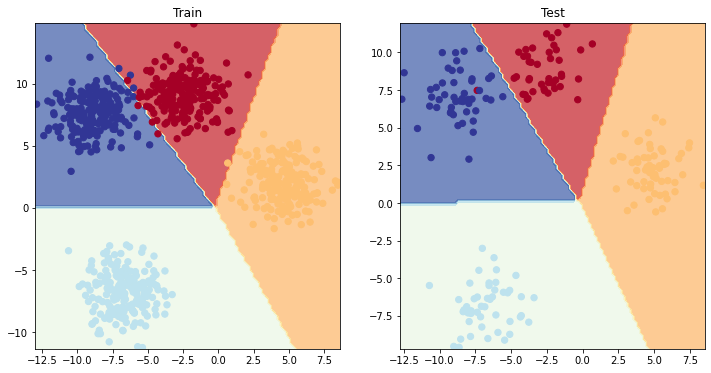

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, x_test, y_test)

##A few more classification metrics... (to evaluate our classification model)

1.Accuracy - out of 100 samples, how many does our model get right?

2.Precision

3.Recall

4.F1-score

5.Confusion matrix

6.Classification report

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 5.1 MB/s 


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy().to(device)

# Calculuate accuracy
torchmetric_accuracy(test_pred, y_test)

tensor(0.9950)

In [ ]:
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(num_classes=4)
confmat(test_pred,y_test)

tensor([[42,  0,  0,  1],
        [ 0, 61,  0,  0],
        [ 0,  0, 47,  0],
        [ 0,  0,  0, 49]])

In [ ]:
y_test

tensor([1, 1, 3, 1, 2, 2, 0, 3, 0, 1, 0, 0, 1, 2, 1, 0, 1, 3, 1, 3, 3, 1, 2, 3,
        2, 1, 0, 3, 2, 3, 1, 3, 1, 0, 1, 0, 3, 1, 2, 0, 0, 3, 1, 2, 1, 2, 3, 0,
        3, 1, 0, 0, 3, 0, 1, 2, 3, 2, 2, 2, 0, 2, 3, 1, 3, 2, 1, 1, 0, 3, 1, 1,
        2, 0, 1, 0, 3, 2, 0, 3, 1, 0, 1, 1, 3, 3, 2, 0, 2, 1, 0, 1, 1, 3, 0, 1,
        3, 3, 2, 2, 2, 1, 1, 1, 1, 2, 3, 2, 3, 3, 2, 0, 3, 0, 3, 2, 2, 1, 0, 3,
        1, 3, 1, 0, 3, 3, 3, 2, 1, 0, 1, 2, 3, 2, 2, 1, 1, 1, 2, 0, 3, 2, 3, 1,
        3, 2, 1, 3, 3, 2, 3, 1, 3, 2, 1, 0, 1, 3, 1, 0, 0, 0, 1, 0, 0, 3, 2, 2,
        0, 2, 1, 1, 1, 3, 1, 0, 1, 1, 3, 2, 1, 0, 2, 0, 1, 0, 3, 2, 2, 1, 2, 2,
        3, 0, 2, 0, 0, 1, 2, 1])